## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
# %matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
from sklearn.cluster import KMeans
# imageio.plugins.ffmpeg.download()

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

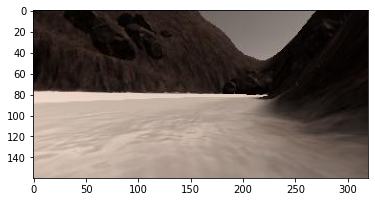

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

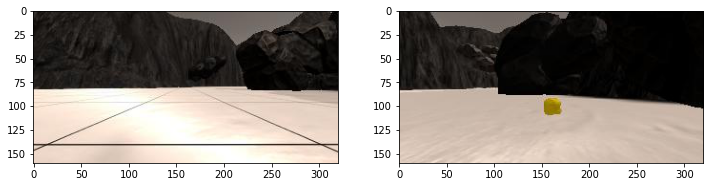

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

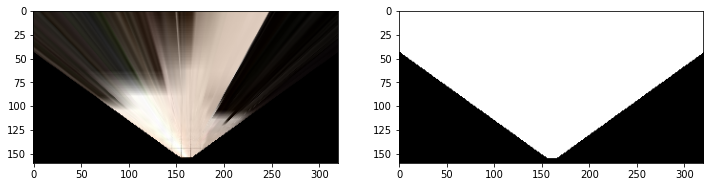

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))
    
    return warped, mask


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped, mask = perspect_transform(grid_img, source, destination)
fig=plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask, cmap='gray')
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

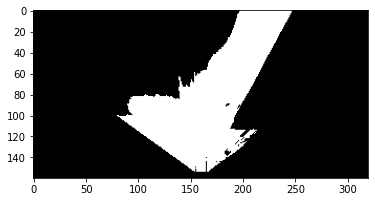

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

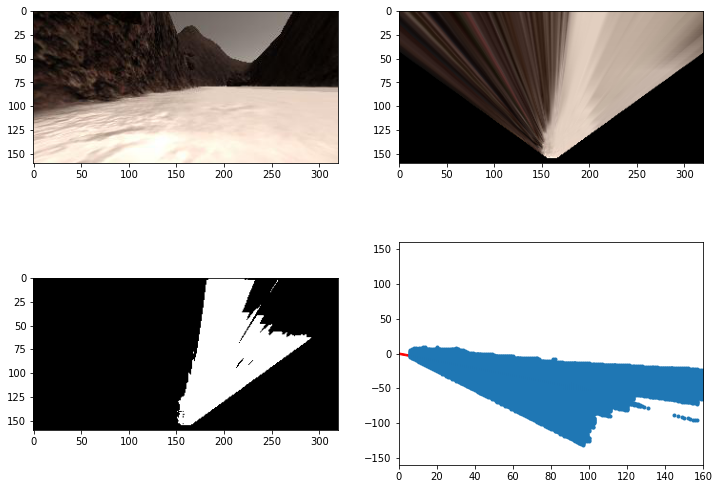

In [7]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped,mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [8]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


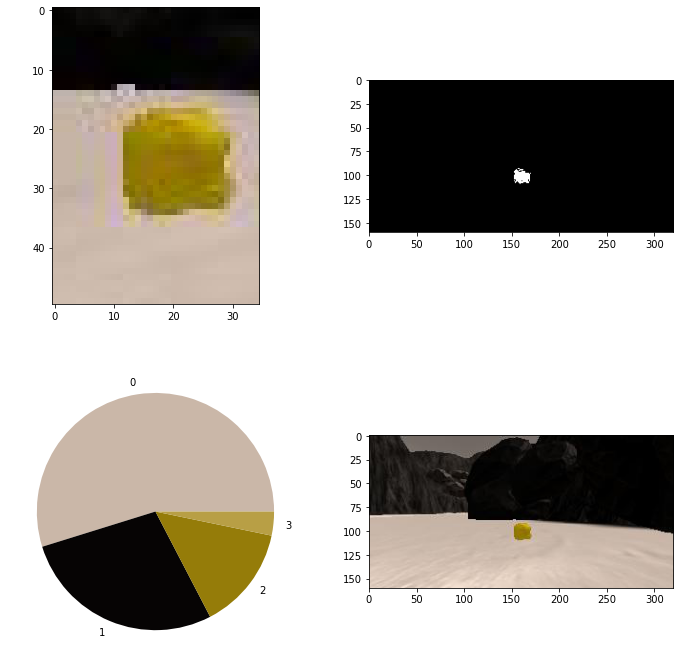

In [25]:
def find_rocks(img, levels=(130,140,30)): #RGB Threshold values for the rock
    rockpix = (( img[:,:,0]>levels[0]) \
                & (img[:,:,1] < levels[1]) \
                & (img[:,:,2] < levels[2]))
    
    color_select=np.zeros_like(img[:,:,0])
    color_select[rockpix]=1
    
    return color_select

fig = plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(rock)
plt.subplot(222)
plt.imshow(rock_map,cmap='gray')
plt.subplot(224)
plt.imshow(rock_img)
plt.subplot(223)
plt.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))
plt.show()

# Using K-Means algorithm to compute RGB threshold values by clustering

In [ ]:
magnified_rock=rock_img[75:125,140:175]
rock=magnified_rock
magnified_rock=magnified_rock.reshape((magnified_rock.shape[1]*magnified_rock.shape[0],3))
kmeans=KMeans(n_clusters=4) #Using 4 clusters
s=kmeans.fit(magnified_rock)
labels=kmeans.labels_
labels=list(labels)
centroid=kmeans.cluster_centers_
percent=[]
for i in range(len(centroid)):
  j=labels.count(i)
  j=j/(len(labels))
  percent.append(j)


# Computing Threshold Values
red_thresh=(centroid[2][0]-15)
green_thresh=(centroid[2][1]+centroid[3][1])/2
blue_thresh=(centroid[2][2]+centroid[3][2])/2

#Applying the threshold on the test rock image using computed RGB threshold values
rock_map = find_rocks(rock_img,levels=(red_thresh, green_thresh, blue_thresh))

[177 150  10]
[177 150  10]


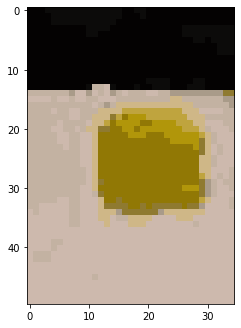

In [16]:
############ Color Quantization
def quantimage(image,k):
    i = np.float32(image).reshape(-1,3)
    condition = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,20,1.0)
    ret,label,center = cv2.kmeans(i, k , None, condition,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    final_img = center[label.flatten()]
    final_img = final_img.reshape(image.shape)
    return final_img

updated_rock_img=quantimage(rock, 10)
fig = plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(updated_rock_img)
print(updated_rock_img[20][20])
print(updated_rock_img[20][23])

## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [11]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
        
    # 6) ######################################################################################################    
    warped,mask = perspect_transform(img, source, destination)
    threshed=color_thresh(warped) # Apply threshold to warped image
    obs_map=np.absolute(np.float32(threshed)-1) * mask
    xpix, ypix = rover_coords(threshed) #Get rover coordinates
    #Convert rover coordinates to world coordinates
    world_size = data.worldmap.shape[0] #3ard el sora
    print(world_size) # will print 200 because the world is 200x200
    scale = 2*dst_size
    xpos = data.xpos[data.count]
    print(xpos)
    ypos = data.ypos[data.count]
    yaw = data.yaw[data.count]
    
    x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos,
                                   yaw, world_size, scale)
    print(x_world , y_world)
    obsxpix, obsypix = rover_coords(obs_map)
    obs_x_world, obs_y_world = pix_to_world(obsxpix, obsypix, xpos, ypos,
                                   yaw, world_size, scale)
    data.worldmap[y_world, x_world, 2] = 255 # Coloring the blue channel for the navigable road
    data.worldmap[obs_y_world, obs_x_world, 0] = 255 # Coloring the red channel for the obstacles
    nav_pix=data.worldmap[:,:,2] > 0 # Getting all pixels in the blue channel which have a value set "greater than 0"
    data.worldmap[nav_pix, 0] = 0 #setting pixels which have a value greater than 0 in the blue channel, to 0 in the red channel
    #to avoid any intersections between the navigable road and the obstacles
    
    
    #################   Finding Rocks
    rock_map= find_rocks(warped, levels=(130,140,50))
    if rock_map.any():
        rock_x, rock_y = rover_coords(rock_map)
        rock_x_world, rock_y_world = pix_to_world(rock_x, rock_y, xpos, ypos,
                                   yaw, world_size, scale)
        data.worldmap[rock_y_world, rock_x_world, :] = 255
    
        
        
        
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img
    
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image
# process_image(image)

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [39]:
# Import everything needed to edit/save/watch video clips
from signal import signal, SIGPIPE,SIG_DFL
import sys
import errno
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip



try:
    # Define pathname to save the output video
    output = '../output/test_mapping3.mp4'
    data = Databucket() # Re-initialize data in case you're running this cell multiple times
    clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                              # recording rate in simulator is fps=25
    new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
    %time new_clip.write_videofile(output, audio=False)
except IOError as e:
    if e.errno == errno.EPIPE:
        signal(SIGPIPE, SIG_DFL)
# frameSize = (200, 200)

# out = cv2.VideoWriter('../output/test_mapping.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 24, frameSize)

# for filename in glob.glob(path):
#     img = cv2.imread(filename)
#     out.write(img)

# out.release()

200
99.66999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
Moviepy - Building video ../output/test_mapping3.mp4.
Moviepy - Writing video ../output/test_mapping3.mp4



t:   2%|▏         | 7/283 [00:00<00:04, 65.10it/s, now=None]

200
99.66999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.66999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.66999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.66999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.66999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.66999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.66999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.66999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67065
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67067
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67067
[111 111 112 ... 100 100 100] [97 97 96 ... 85 85 85]
200
99.67066
[111 111 112 ... 100 100 100] [97 97 96 ... 85 85 85]
200
99.67066
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67065
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]


t:   9%|▉         | 25/283 [00:00<00:03, 80.58it/s, now=None]

200
99.67065
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67064
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67064
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67063
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67062
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67062
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67062
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67062
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67062
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.6708
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67083000000001
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67175999999999
[111 111 111 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67331999999999
[111 111 111 ... 100 100 100] [97 97 96 ... 85 85 85]
200
99.67529
[109 109 109 ... 100 100 100] [97 97 97 ... 85 85 85]
200
99.67777
[111 111 111 ... 100 10

t:  15%|█▍        | 42/283 [00:00<00:03, 76.01it/s, now=None]

[107 107 108 ... 100 100 100] [99 99 99 ... 85 85 85]
200
99.70283
[105 106 106 ... 100 100 100] [100 100 100 ...  85  85  85]
200
99.71024
[105 105 105 ... 100 100 100] [101 100 100 ...  85  85  85]
200
99.71786999999999
[105 105 105 ... 100 100 100] [101 101 101 ...  86  85  85]
200
99.72574
[105 105 105 ... 100 100 100] [101 101 101 ...  86  85  85]
200
99.73706999999999
[105 105 105 ... 100 100 100] [101 101 101 ...  86  85  85]
200
99.74576
[105 105 105 ... 100 100 100] [101 101 101 ...  86  85  85]
200
99.76088
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  85]
200
99.77776
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  85]
200
99.79700000000001
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
99.81023
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
99.83139
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
99.84605
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
99.86151
[105 105 105 ... 100 100 100] 

t:  20%|██        | 58/283 [00:00<00:02, 75.33it/s, now=None]

200
99.90364
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
99.92182
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
99.95082
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
99.97074
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
99.99143000000001
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
100.0236
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
100.0459
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
100.0807
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
100.1048
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
100.1422
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
100.1679
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
100.2078
[105 105 105 ... 100 100 100] [101 101 101 ...  86  86  86]
200
100.2352
[105 105 105 ... 100 100 100] [102 101 101 ...  86  86  86]
200
100.2775
[105 105 105 ... 100 100 101]

t:  24%|██▎       | 67/283 [00:00<00:02, 78.21it/s, now=None]

200
100.382
[105 105 105 ... 100 101 101] [102 102 102 ...  87  86  86]
200
100.4134
[105 105 105 ... 100 101 101] [102 102 102 ...  87  87  86]
200
100.4454
[105 105 105 ... 101 101 101] [102 102 102 ...  87  87  87]
200
100.4947
[105 105 105 ... 101 101 101] [102 102 102 ...  87  87  87]
200
100.5284
[105 105 105 ... 101 101 101] [102 102 102 ...  87  87  87]
200
100.5801
[105 105 105 ... 101 101 101] [102 102 102 ...  87  87  87]
200
100.6154
[105 105 105 ... 101 101 101] [102 102 102 ...  87  87  87]
200
100.6696
[105 105 105 ... 101 101 101] [102 102 102 ...  87  87  87]
200
100.7065
[105 105 105 ... 101 101 101] [103 102 102 ...  87  87  87]
200
100.7441
[105 105 105 ... 101 101 101] [103 103 103 ...  87  87  87]
200
100.8016
[105 105 105 ... 101 101 101] [103 103 103 ...  87  87  87]
200
100.8408
[105 105 105 ... 101 101 101] [103 103 103 ...  87  87  87]


t:  27%|██▋       | 75/283 [00:01<00:02, 70.26it/s, now=None]

200
100.9008
[105 105 105 ... 101 101 101] [103 103 103 ...  87  87  87]
200
100.9416
[105 105 105 ... 101 101 101] [103 103 103 ...  87  87  87]


t:  29%|██▉       | 83/283 [00:01<00:02, 67.35it/s, now=None]

200
100.98299999999999
[105 105 105 ... 101 101 101] [103 103 103 ...  87  87  87]
200
101.0463
[105 105 105 ... 101 101 101] [103 103 103 ...  88  88  87]
200
101.0892
[105 105 105 ... 101 101 101] [103 103 103 ...  88  88  88]
200
101.1536
[105 105 105 ... 101 101 101] [104 103 103 ...  88  88  88]
200
101.1962
[105 105 105 ... 101 101 101] [104 104 103 ...  88  88  88]
200
101.2594
[105 105 105 ... 101 101 101] [104 104 104 ...  88  88  88]
200
101.3006
[105 105 105 ... 101 101 102] [104 104 104 ...  88  88  88]
200
101.3412
[105 105 105 ... 101 101 102] [104 104 104 ...  88  88  88]
200
101.4032
[105 105 105 ... 101 102 102] [104 104 104 ...  88  88  88]
200
101.4455
[105 106 106 ... 101 102 102] [104 104 104 ...  88  88  88]
200
101.4889
[105 105 106 ... 102 102 102] [104 104 104 ...  88  88  88]
200
101.5549
[105 105 106 ... 102 102 102] [104 104 104 ...  89  89  88]


t:  34%|███▍      | 97/283 [00:01<00:02, 62.34it/s, now=None]

200
101.5995
[105 105 105 ... 102 102 102] [104 104 104 ...  89  89  89]
200
101.6669
[106 106 106 ... 102 102 102] [104 104 104 ...  89  89  89]
200
101.7122
[105 105 105 ... 102 102 102] [104 104 104 ...  89  89  89]
200
101.7581
[105 105 105 ... 102 102 102] [105 104 104 ...  89  89  89]
200
101.8279
[106 106 106 ... 102 102 102] [105 104 104 ...  89  89  89]
200
101.8742
[106 106 106 ... 102 102 102] [105 104 104 ...  89  89  89]
200
101.92
[106 106 106 ... 102 102 102] [105 104 104 ...  89  89  89]
200
101.9889
[106 106 106 ... 102 102 102] [105 104 104 ...  89  89  89]
200
102.0354
[107 107 107 ... 102 102 102] [104 104 104 ...  89  89  89]
200
102.1059
[107 107 107 ... 102 102 102] [105 105 105 ...  90  90  90]
200
102.1525
[107 107 107 ... 102 102 102] [105 105 105 ...  90  90  90]
200
102.1983
[107 107 107 ... 102 102 102] [105 105 105 ...  90  90  90]
200
102.2668
[107 107 107 ... 102 102 102] [105 105 105 ...  90  90  90]
200
102.3126
[107 107 107 ... 102 102 103] [105 105 1

t:  40%|███▉      | 113/283 [00:01<00:02, 62.81it/s, now=None]

[107 107 107 ... 102 102 103] [105 105 105 ...  90  90  90]
200
102.4286
[107 107 107 ... 102 103 103] [105 105 105 ...  90  90  90]
200
102.4752
[107 107 107 ... 102 103 103] [105 105 105 ...  90  90  90]
200
102.5432
[107 107 107 ... 103 103 103] [105 105 105 ...  91  91  91]
200
102.5876
[107 107 108 ... 103 103 103] [105 105 105 ...  91  91  91]
200
102.6548
[108 108 108 ... 103 103 103] [106 105 105 ...  91  91  91]
200
102.6999
[108 108 108 ... 103 103 103] [106 106 106 ...  91  91  91]
200
102.766
[108 108 108 ... 103 103 103] [106 106 106 ...  91  91  91]
200
102.8079
[108 108 108 ... 103 103 103] [106 106 106 ...  91  91  91]
200
102.8484
[108 109 109 ... 103 103 103] [106 106 106 ...  91  91  91]
200
102.90700000000001
[109 109 109 ... 103 103 103] [106 106 106 ...  92  92  92]
200
102.9441
[110 110 110 ... 103 103 103] [106 106 106 ...  92  92  92]


t:  42%|████▏     | 120/283 [00:01<00:02, 61.43it/s, now=None]

200
102.9981
[111 111 111 ... 103 103 103] [106 106 106 ...  92  92  92]
200
103.0315
[114 114 114 ... 103 103 103] [105 105 105 ...  92  92  92]
200
103.0779
[117 117 117 ... 103 103 103] [105 105 105 ...  92  92  92]
200
103.1073
[117 117 118 ... 103 103 103] [105 105 105 ...  92  92  92]
200
103.1502
[117 117 118 ... 103 103 103] [105 105 105 ...  93  93  93]
200
103.1788
[119 119 120 ... 103 103 103] [105 105 105 ...  93  93  93]
200
103.2078
[120 120 120 ... 103 103 103] [105 105 105 ...  93  93  93]
200
103.2514
[120 120 120 ... 103 103 103] [105 105 105 ...  93  93  93]
200
103.2809
[120 119 119 ... 103 103 103] [105 104 104 ...  93  93  93]
200
103.3109
[120 120 120 ... 103 103 103] [106 105 105 ...  93  93  93]
200
103.3565
[118 118 118 ... 103 103 103] [104 104 104 ...  94  94  94]
200
103.3872
[120 120 121 ... 103 103 104] [106 106 106 ...  94  94  94]


t:  47%|████▋     | 134/283 [00:02<00:02, 58.54it/s, now=None]

200
103.4181
[120 120 121 ... 103 103 104] [106 106 106 ...  94  94  94]
200
103.465
[120 120 121 ... 103 103 104] [106 106 106 ...  94  94  94]
200
103.4968
[120 121 121 ... 103 104 104] [106 106 106 ...  94  94  94]
200
103.5464
[122 122 122 ... 103 104 104] [105 105 105 ...  94  94  94]
200
103.5813
[121 121 121 ... 104 104 104] [106 106 106 ...  95  95  95]
200
103.6179
[121 121 121 ... 104 104 104] [106 106 106 ...  95  95  95]
200
103.6753
[118 118 118 ... 104 104 104] [107 107 107 ...  95  95  95]
200
103.7159
[117 117 117 ... 104 104 104] [107 107 107 ...  95  95  95]
200
103.7826
[117 117 117 ... 104 104 104] [107 107 107 ...  95  95  95]
200
103.8311
[117 118 118 ... 104 104 104] [107 107 107 ...  95  95  95]
200
103.8835
[118 118 118 ... 104 104 104] [107 107 107 ...  96  96  95]
200
103.9723
[119 119 119 ... 104 104 104] [106 106 106 ...  96  96  96]


t:  52%|█████▏    | 146/283 [00:02<00:02, 56.30it/s, now=None]

200
104.0359
[120 120 120 ... 104 104 104] [106 106 106 ...  96  96  96]
200
104.1021
[120 120 120 ... 104 104 104] [105 105 105 ...  96  96  96]
200
104.2066
[120 120 121 ... 104 104 104] [105 105 105 ...  96  96  96]
200
104.2803
[120 120 120 ... 104 104 105] [105 105 105 ...  96  96  96]
200
104.4
[120 120 120 ... 104 105 105] [105 105 105 ...  96  96  96]
200
104.4846
[120 120 120 ... 105 105 105] [105 105 105 ...  97  97  97]
200
104.574
[120 120 120 ... 105 105 105] [105 105 105 ...  97  97  97]
200
104.71799999999999
[120 120 120 ... 105 105 105] [105 105 105 ...  97  97  97]
200
104.8186
[120 120 120 ... 105 105 105] [105 105 105 ...  97  97  97]
200
104.9224
[120 120 120 ... 105 105 105] [105 105 105 ...  97  97  97]
200
105.0851
[120 120 120 ... 105 105 105] [105 105 105 ...  97  97  97]
200
105.1978
[120 120 120 ... 105 105 105] [105 105 105 ...  97  97  97]
200
105.3751
[120 120 120 ... 106 106 106] [105 105 105 ...  98  97  97]
200
105.4971
[120 120 120 ... 106 106 106] [1

t:  57%|█████▋    | 161/283 [00:02<00:02, 57.63it/s, now=None]

200
105.6225
[120 120 120 ... 106 106 106] [105 105 105 ...  98  98  98]
200
105.7513
[120 120 120 ... 106 106 106] [105 105 105 ...  98  98  98]
200
105.9511
[120 120 120 ... 106 106 106] [105 105 105 ...  98  98  98]
200
106.0881
[120 120 120 ... 106 106 106] [105 105 105 ...  98  98  98]
200
106.2282
[120 120 120 ... 106 106 107] [105 105 105 ...  98  98  98]
200
106.4444
[121 121 121 ... 107 107 107] [105 105 105 ...  98  98  98]
200
106.59200000000001
[121 121 121 ... 107 107 107] [105 104 104 ...  98  98  98]
200
106.7424
[121 121 121 ... 107 107 107] [104 104 104 ...  98  98  98]
200
106.9736
[122 122 122 ... 107 107 107] [104 104 104 ...  98  98  98]
200
107.1309
[122 122 122 ... 107 107 107] [104 104 104 ...  99  98  98]
200
107.2907
[122 122 122 ... 107 108 108] [104 104 103 ...  99  99  98]


t:  61%|██████    | 173/283 [00:02<00:01, 56.84it/s, now=None]

200
107.45299999999999
[122 122 122 ... 108 108 108] [103 103 103 ...  99  99  98]
200
107.7011
[123 123 123 ... 108 108 108] [103 103 103 ...  99  99  99]
200
107.8691
[123 123 123 ... 108 108 108] [103 103 102 ...  99  99  99]
200
108.039
[123 123 123 ... 108 108 108] [103 102 102 ...  99  99  99]
200
108.2115
[124 124 124 ... 108 108 108] [102 102 102 ...  99  99  99]
200
108.4734
[124 124 124 ... 109 109 109] [101 101 101 ...  99  99  99]
200
108.6505
[124 124 124 ... 109 109 109] [101 101 101 ...  99  99  99]
200
108.8291
[124 124 124 ... 109 109 109] [101 101 100 ...  99  99  99]
200
109.1
[125 125 124 ... 109 109 109] [100 100 100 ...  99  99  99]
200
109.2824
[119 119 119 ... 109 109 109] [100 100 100 ...  99  99  99]
200
109.4658
[118 118 118 ... 110 110 110] [100 100 100 ...  99  99  99]
200
109.6512
[119 119 119 ... 110 110 110] [100 100 100 ...  99  99  99]
200
109.8367
[120 120 120 ... 110 110 110] [100 100 100 ...  99  99  99]


t:  66%|██████▌   | 186/283 [00:02<00:01, 58.80it/s, now=None]

200
110.1172
[118 118 118 ... 110 110 110] [102 102 100 ...  99  99  99]
200
110.305
[118 118 118 ... 110 110 110] [103 103 102 ...  99  99  99]
200
110.4939
[118 118 118 ... 111 111 111] [102 102 102 ...  99  99  99]
200
110.7779
[119 118 118 ... 111 111 111] [102 101 101 ...  99  99  99]
200
110.9682
[119 119 119 ... 111 111 111] [101 101 101 ...  99  99  99]
200
111.1586
[120 119 119 ... 111 111 111] [102 101 101 ...  99  99  99]
200
111.4444
[119 119 119 ... 111 111 111] [101 101 101 ...  99  99  99]
200
111.6347
[121 120 120 ... 112 112 112] [102 101 101 ...  99  99  99]
200
111.9206
[120 120 120 ... 112 112 112] [101 101 101 ...  99  99  99]
200
112.1109
[120 120 120 ... 112 112 112] [101 101 101 ...  99  99  98]
200
112.3008
[122 122 121 ... 112 112 112] [100 100 100 ...  99  98  98]
200
112.5858
[121 121 121 ... 113 113 113] [101 101 101 ...  99  98  98]


t:  68%|██████▊   | 192/283 [00:03<00:01, 56.38it/s, now=None]

200
112.77600000000001
[121 121 121 ... 113 113 113] [101 101 101 ...  98  98  98]
200
112.9664
[121 121 121 ... 113 113 113] [101 101 101 ...  98  98  98]
200
113.1575
[121 121 121 ... 113 113 113] [101 100 100 ...  98  98  98]
200
113.4448
[121 121 121 ... 113 113 113] [101 101 101 ...  98  98  98]
200
113.6363
[122 122 122 ... 114 114 114] [101 101 101 ...  98  98  98]
200
113.82799999999999
[123 122 122 ... 114 114 114] [102 101 101 ...  98  98  98]
200
114.02
[123 123 123 ... 114 114 114] [101 102 101 ...  98  98  98]
200
114.3093
[125 124 124 ... 114 114 114] [102 102 102 ...  98  98  98]
200
114.5023
[124 124 124 ... 114 114 114] [102 102 102 ...  98  98  98]
200
114.7918
[126 126 126 ... 115 115 115] [101 101 101 ...  98  98  98]


t:  70%|███████   | 199/283 [00:03<00:01, 58.61it/s, now=None]

200
114.9853
[133 133 133 ... 115 115 115] [103 103 103 ...  98  98  98]
200
115.179
[134 134 134 ... 115 115 115] [106 106 106 ...  98  98  97]


t:  73%|███████▎  | 206/283 [00:03<00:01, 60.26it/s, now=None]

200
115.3727
[135 135 135 ... 115 115 115] [109 108 108 ...  98  98  98]
200
115.5666
[135 135 135 ... 116 116 116] [108 108 108 ...  98  98  97]
200
115.7608
[135 135 135 ... 116 116 116] [108 108 108 ...  98  97  97]
200
116.0503
[136 136 136 ... 116 116 116] [108 108 108 ...  98  97  97]
200
116.3369
[136 136 136 ... 116 116 116] [108 108 108 ...  98  97  97]
200
116.5242
[136 136 136 ... 117 116 116] [108 108 108 ...  97  97  97]
200
116.8111
[136 136 136 ... 117 117 117] [108 108 108 ...  97  97  97]
200
117.0034
[136 136 136 ... 117 117 117] [109 109 108 ...  97  97  97]
200
117.2933
[136 136 136 ... 117 117 117] [109 109 109 ...  97  97  97]
200
117.4871
[136 136 136 ... 118 117 117] [109 109 109 ...  97  97  97]
200
117.68
[136 136 136 ... 118 118 118] [110 110 109 ...  97  97  97]
200
117.9688
[136 136 136 ... 118 118 118] [110 110 110 ...  97  97  97]
200
118.2582


t:  76%|███████▌  | 214/283 [00:03<00:01, 64.63it/s, now=None]

[136 136 136 ... 118 118 118] [111 111 111 ...  97  97  97]
200
118.45100000000001
[136 136 136 ... 119 119 119] [111 111 111 ...  97  97  97]
200
118.7448
[135 135 135 ... 119 119 119] [112 112 112 ...  97  97  97]


t:  78%|███████▊  | 222/283 [00:03<00:00, 68.16it/s, now=None]

200
118.9432
[135 135 135 ... 119 119 119] [112 112 112 ...  97  97  97]
200
119.1435
[135 135 135 ... 119 119 119] [113 112 112 ...  97  97  97]
200
119.3457
[135 135 135 ... 119 119 119] [113 113 113 ...  97  97  97]
200
119.648
[135 135 135 ... 120 120 120] [113 113 113 ...  97  97  97]
200
119.8473
[135 135 135 ... 120 120 120] [114 114 114 ...  98  97  97]
200
120.0456
[134 134 134 ... 120 120 120] [114 114 114 ...  98  97  97]
200
120.3433
[134 134 134 ... 121 120 120] [115 115 115 ...  97  98  98]
200
120.542
[134 134 134 ... 121 121 121] [115 115 115 ...  98  98  97]
200
120.7399
[133 133 133 ... 121 121 121] [116 116 115 ...  98  98  98]
200
120.9374
[133 133 133 ... 121 121 121] [116 116 116 ...  98  98  98]
200
121.2334
[133 133 133 ... 121 121 121] [116 116 116 ...  98  98  97]
200
121.5259
[133 133 133 ... 122 121 122] [117 117 117 ...  98  98  98]
200
121.7197
[132 132 132 ... 122 122 122] [117 117 117 ...  98  98  98]


t:  81%|████████  | 229/283 [00:03<00:00, 67.57it/s, now=None]

200
121.9125
[132 132 132 ... 122 122 122] [117 117 117 ...  98  98  98]


t:  83%|████████▎ | 236/283 [00:03<00:00, 62.61it/s, now=None]

200
122.2004
[132 132 132 ... 122 122 122] [118 118 118 ...  98  98  98]
200
122.4851
[132 132 132 ... 123 122 122] [118 118 118 ...  99  98  98]
200
122.6679
[132 132 132 ... 123 123 123] [118 118 118 ... 100  99  99]
200
122.9464
[131 131 131 ... 123 123 123] [119 119 119 ... 100 100 100]
200
123.1339
[131 131 131 ... 123 123 123] [119 119 119 ... 100 100 100]
200
123.3191
[131 131 131 ... 124 123 123] [119 119 119 ... 100 100  99]
200
123.5918
[131 131 131 ... 124 124 124] [119 119 119 ... 100  99  99]


t:  89%|████████▉ | 252/283 [00:03<00:00, 59.71it/s, now=None]

200
123.7709
[130 130 130 ... 124 124 124] [120 120 120 ... 100  99  99]
200
124.0329
[130 130 130 ... 124 124 124] [120 120 120 ... 100  99  99]
200
124.1952
[130 130 130 ... 124 124 124] [120 120 120 ... 100 100 100]
200
124.4504
[129 129 129 ... 124 124 124] [121 121 120 ... 100 100  99]
200
124.61399999999999
[129 129 129 ... 124 124 124] [121 121 121 ... 100 100 100]
200
124.7715
[129 129 129 ... 124 125 125] [121 121 121 ... 100 100 100]
200
124.9258
[128 128 128 ... 125 125 125] [121 121 121 ... 100 100 100]
200
125.1665
[128 128 128 ... 125 125 125] [122 121 121 ... 100 100 100]
200
125.3292
[128 128 128 ... 125 125 125] [122 122 121 ... 100 100 100]
200
125.4924
[128 128 128 ... 125 125 125] [122 122 122 ... 100 100 100]
200
125.6582
[129 129 129 ... 125 125 125] [122 122 122 ... 100 100 100]
200
125.9136
[129 129 129 ... 126 126 126] [122 122 122 ... 100 100 100]
200
126.0835
[129 129 129 ... 126 126 126] [122 122 122 ... 101 100 100]
200
126.2527
[130 130 130 ... 126 126 126

t:  92%|█████████▏| 259/283 [00:04<00:00, 58.99it/s, now=None]

200
126.6739
[130 130 130 ... 127 126 126] [122 122 122 ... 101 101 101]
200
126.9228
[130 130 130 ... 127 127 127] [123 123 122 ... 101 101 101]
200
127.083
[135 135 135 ... 127 127 127] [116 116 116 ... 101 101 101]
200
127.2413
[138 139 139 ... 127 127 127] [112 112 112 ... 101 101 101]
200
127.3975
[140 140 140 ... 127 127 127] [110 110 110 ... 101 101 101]
200
127.6294
[141 141 141 ... 127 128 128] [109 109 109 ... 101 101 101]
200
127.7847
[144 144 144 ... 128 128 128] [106 106 106 ... 101 101 101]
200
127.9421
[147 147 147 ... 128 128 128] [102 102 101 ... 101 101 101]
200
128.1833
[143 143 143 ... 128 128 128] [103 103 103 ... 102 102 101]
200
128.3457
[143 143 142 ... 128 128 128] [103 103 103 ... 102 102 102]
200
128.59
[144 143 143 ... 129 129 129] [103 103 103 ... 102 102 102]
200
128.7528
[147 138 138 ... 129 129 129] [103 113 113 ... 102 102 102]
200
128.9153
[135 142 142 ... 129 129 129] [120 111 111 ... 102 102 102]


200
129.1584
[132 132 132 ... 129 129 129] [124 124 124 ... 102 102 102]
200
129.3197
[132 132 132 ... 129 130 130] [125 124 124 ... 102 102 102]
200
129.5601
[132 132 132 ... 130 130 130] [125 125 125 ... 102 102 102]
200
129.719
[132 133 133 ... 130 130 130] [125 125 125 ... 103 103 102]
200
129.8772
[133 133 133 ... 130 130 130] [125 125 125 ... 103 103 103]
200
130.1134
[140 140 140 ... 130 130 130] [115 115 115 ... 103 103 103]
200
130.2701
[139 139 139 ... 130 130 131] [114 114 114 ... 103 103 103]
200
130.5043
[130 132 133 ... 131 131 131] [120 117 116 ... 103 103 103]
200
130.6604
[137 136 137 ... 131 131 131] [111 111 111 ... 103 103 103]
200
130.8163
[136 136 136 ... 131 131 131] [111 111 110 ... 103 103 103]
200
131.0498
[136 136 136 ... 131 131 131] [111 111 111 ... 104 103 103]
200
131.2048
[135 135 135 ... 131 131 131] [110 109 109 ... 104 104 104]
200
131.3598
[135 135 135 ... 132 132 132] [109 109 109 ... 104 104 104]
200
131.5917
[135 135 135 ... 132 132 132] [110 110 

Moviepy - Done !
Moviepy - video ready ../output/test_mapping3.mp4
CPU times: user 3.6 s, sys: 204 ms, total: 3.81 s
Wall time: 4.56 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [40]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [41]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))